In [1]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.coordinates import SkyCoord
import astropy.units as u

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#3F8FCE', '#7ABBCE', '#3A3865', '#A82F43', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('serif')
font.set_name('Andale Mono')
font.set_style('normal')
#font.set_size('normal')


%matplotlib inline  

# Elementary statistical analysis of `LINEAR` and `ZTF` light curve data
---


*Authors: Ema Donev and dr. Ivezić*

In this notebook we are taking a look at the basic statistical measures of magnitude data, plotting light curves from both databases and taking a look at phased light curves with our preliminary periods. 

There are a total of 2710 RR Lyrae stars being analysed in this paper. Taking a look into the amount of observations, we can see that:

In [2]:
#| code-fold: false
# LINEAR DATA
# ------------
end = 'ffinal'
datalinear = fetch_LINEAR_sample(data_home='../inputs')
dataL = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
dataZ = np.load('../outputs/ZTF_dataset_'+'end'+'.npy', allow_pickle=True)

In [3]:
dataL.head()

,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,LINEARobjectID
0,119.526443,46.962120,1.166,0.369,1.018,0.269,-0.254138,0.619,-0.313,-0.567,16.37,301,1,29848
1,119.712975,52.149574,1.175,0.386,1.100,0.205,-0.191591,0.487,-0.291,-0.879,16.46,284,1,50402
2,119.187241,53.379295,1.123,0.207,1.074,0.210,-0.275092,0.624,-0.547,-0.322,16.54,276,1,62892
3,120.294960,40.932457,1.180,0.237,1.087,0.368,-0.170871,0.753,-0.121,-0.927,15.39,177,1,91437
4,120.124542,40.656620,1.178,-0.145,0.835,0.277,-0.503252,0.550,0.140,-0.650,16.98,222,2,95250


In [4]:
# NUMBER OF MEASUREMENTS
# -----------------------
pL = []
ids = dataL['LINEARobjectID'].to_numpy()
for i in ids:
    lc = datalinear.get_light_curve(i)
    t, m, me = lc.T
    pL.append(len(t))

pZf1 = []
pZf2 = []
pZf3 = []
bands = ['zg','zr','zi']
for i in range(len(ids)):
    for j in dataL['LINEARobjectID'].to_numpy():
        if dataZ[i][0]==j:
            lc = dataZ[i][1]
            break
    if lc.empty:
        t1 = []
        t2 = []
        t3 = []
    else:
        t1 = lc.loc[lc['filtercode']=='zg']['mjd'].to_numpy()
        t2 = lc.loc[lc['filtercode']=='zr']['mjd'].to_numpy()
        t3 = lc.loc[lc['filtercode']=='zi']['mjd'].to_numpy()
    pZf1.append(len(t1))
    pZf2.append(len(t2))
    pZf3.append(len(t3))

total_obserL = sum(pL) # summing the number of measurements of every light curve
print(f'LINEAR contains {total_obserL} observations, with an average of {round(total_obserL/len(ids), 4)} observations.')

total_obserZ1 = sum(pZf1)
total_obserZ2 = sum(pZf2)
total_obserZ3 = sum(pZf3)
print(f'ZTF contains {total_obserZ1} observations in the green filter, {total_obserZ2} observations in the red filter and {total_obserZ3} observations in the infrared filter.')
print(f'ZTF green average is {round(total_obserZ1/len(pZf1), 4)} observations, red average is {round(total_obserZ2/len(pZf2), 4)} observations and the infrared average is {round(total_obserZ3/len(pZf3), 4)} observations.')

LINEAR contains 791496 observations, with an average of 269.1248 observations.
ZTF contains 1533749 observations in the green filter, 1910504 observations in the red filter and 363046 observations in the infrared filter.
ZTF green average is 521.506 observations, red average is 649.6103 observations and the infrared average is 123.443 observations.


From this we can conclude that `ZTF` has considerably more observations in total than `LINEAR`, and it has higher averages per each filter except for the infrared filter, which has only 125.2815 observations on average. We can also draw a distribution graph to visualize this better:

In [29]:
plt.rcParams.update({
    'font.serif': 'Andale Mono',
    'font.family': 'serif'
})

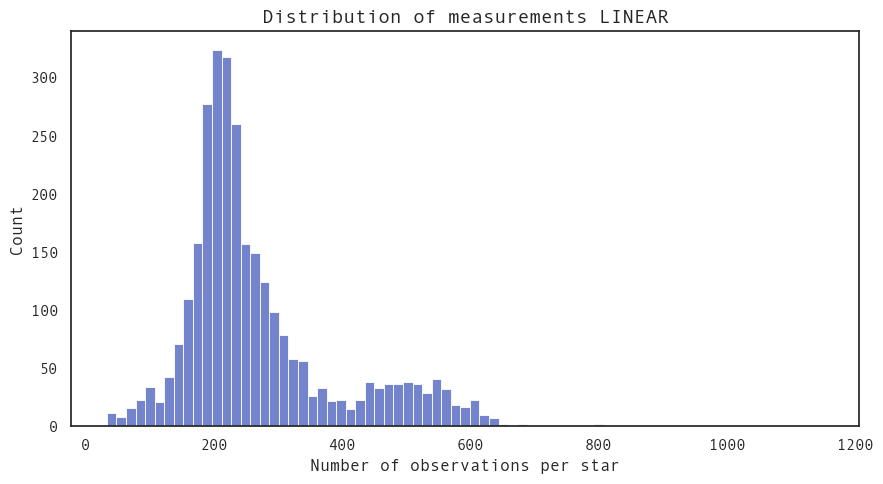

In [35]:
plt.figure(figsize=(9,5))
sns.histplot(data=pL,color=b1) # drawing a histogram of the distribution of measurements
plt.title('Distribution of measurements LINEAR', fontproperties=font,fontsize=14)
plt.xlabel('Number of observations per star', fontproperties=font, fontsize=12)
plt.ylabel('Count', fontproperties=font,fontsize=12)
plt.savefig('../img_rsc/LINEAR_observations_distribution.png', dpi=650)
plt.tight_layout()
plt.show()

The distribution really shows that the average is ~200 observation points for `LINEAR` stars, with a subsequent peak at ~500 observations, however this is minimal.

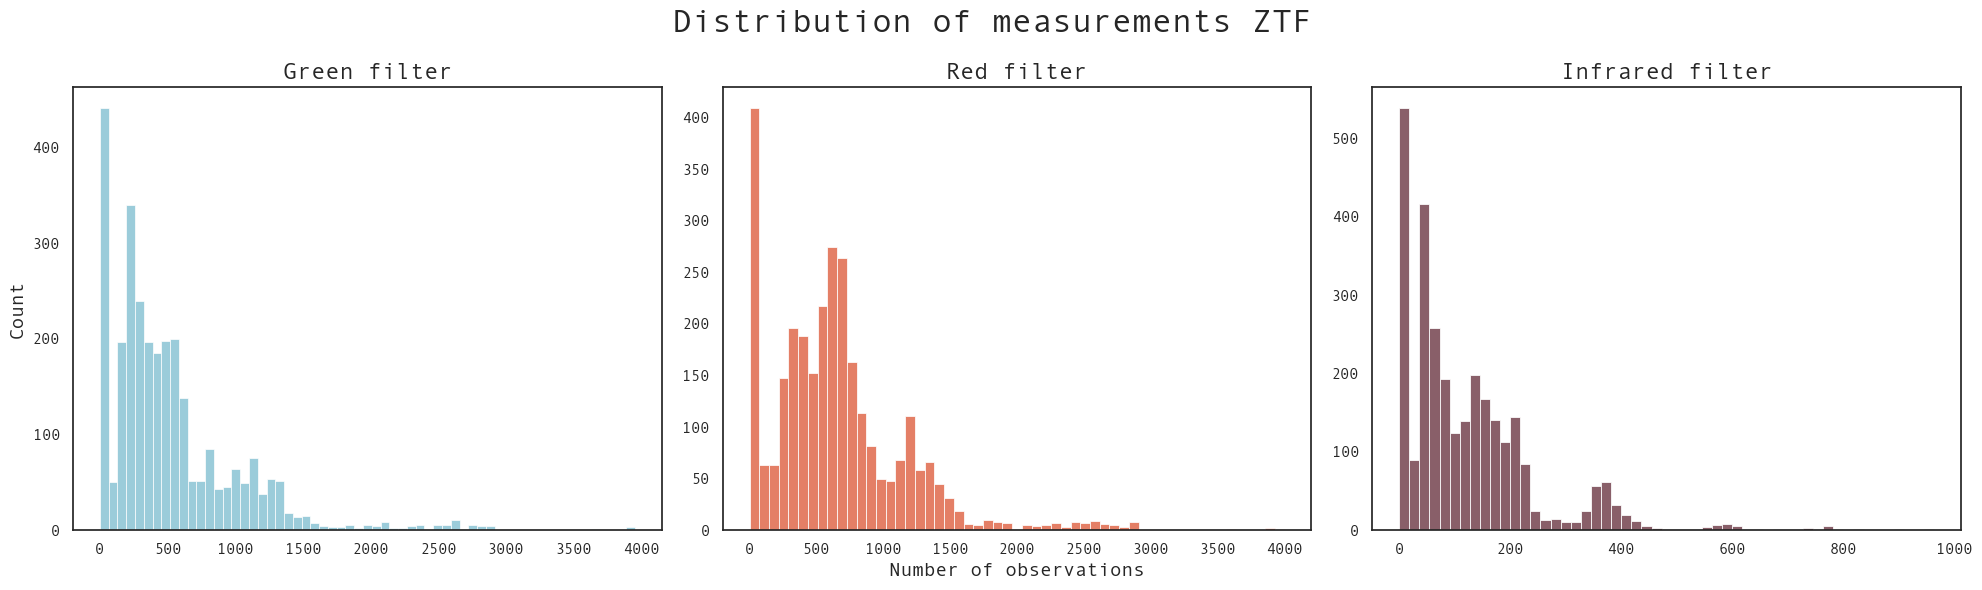

In [34]:
fig, ax = plt.subplots(1,3, figsize=(20,6)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes

fig.suptitle('Distribution of measurements ZTF', fontproperties=font,fontsize=24)

sns.histplot(data=pZf1,color=b3, ax=ax[0]) # drawing a histogram of the distribution of measurements
sns.histplot(data=pZf2,color=or3, ax=ax[1])
sns.histplot(data=pZf3,color=or2, ax=ax[2])

ax[1].set_xlabel('Number of observations', fontproperties=font, fontsize=14)
ax[0].set_ylabel('Count', fontproperties=font,fontsize=14)
ax[1].set_ylabel(None)
ax[2].set_ylabel(None)
ax[0].set_title('Green filter', fontproperties=font, fontsize=17)
ax[1].set_title('Red filter', fontproperties=font, fontsize=17)
ax[2].set_title('Infrared filter', fontproperties=font, fontsize=17)
plt.savefig('../img_rsc/ZTF_observations_distribution.png', dpi=650)
plt.tight_layout()
plt.show()

For `ZTF`, all the distributions have a similar shape, however the infrared graph has a lower x-axis scale. The green filter has a peak at less than ~100 observations, and the subsequent one is at ~400-500 observation points. A very similar situation is with the red filter, with a slightly higher peak at ~500-600 observations. The infrared filter has the lowest amount of points, with most stars below ~50 points, with a subsequent peak at ~100 points. 

In our later analysis, it will be important to have stars with above ~250 observations points so we can conduct proper Blazhko analysis. 

Another important aspect is the time period each star was observed for. How many seasons, years or days was a particular star observed for?

In [36]:
# NUMBER OF MEASUREMENTS
# -----------------------
pL = []
ids = dataL['LINEARobjectID'].to_numpy()
for i in ids:
    lc = datalinear.get_light_curve(i)
    t, m, me = lc.T
    pL.append(t[-1]-t[0])

pZf1 = []
pZf2 = []
pZf3 = []
bands = ['zg','zr','zi']
for i in range(len(ids)):
    for j in dataL['LINEARobjectID'].to_numpy():
        if dataZ[i][0]==j:
            lc = dataZ[i][1]
            break
    if lc.empty or lc.loc[lc['filtercode']=='zg'].empty or lc.loc[lc['filtercode']=='zr'].empty or lc.loc[lc['filtercode']=='zi'].empty:
        t1 = []
        t2 = []
        t3 = []
        pZf1.append(0)
        pZf2.append(0)
        pZf3.append(0)
    else:
        t1 = lc.loc[lc['filtercode']=='zg']['mjd'].to_numpy()
        t2 = lc.loc[lc['filtercode']=='zr']['mjd'].to_numpy()
        t3 = lc.loc[lc['filtercode']=='zi']['mjd'].to_numpy()
        pZf1.append(t1[-1]-t1[0])
        pZf2.append(t2[-1]-t2[0])
        pZf3.append(t3[-1]-t3[0])

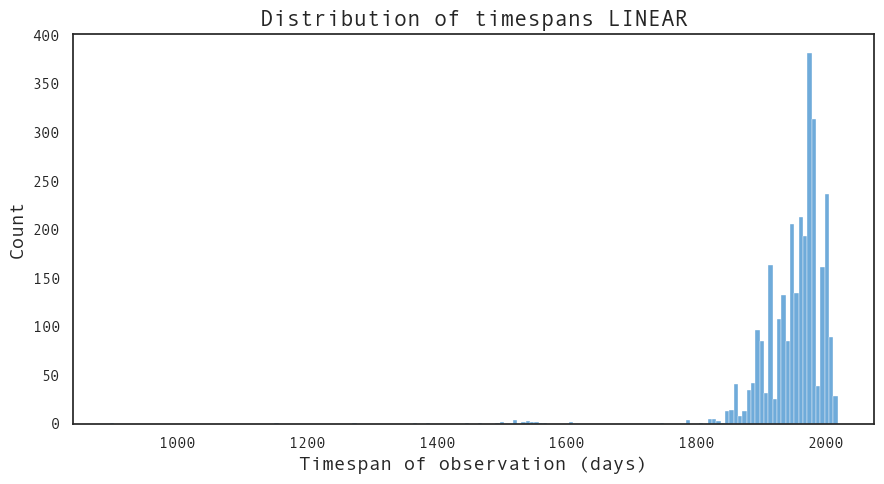

In [39]:
plt.figure(figsize=(9,5))
sns.histplot(data=pL,color=b2) # drawing a histogram of the distribution of measurements
plt.title('Distribution of timespans LINEAR', fontproperties=font,fontsize=16)
plt.xlabel('Timespan of observation (days)', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/LINEAR_timespan_distribution.png', dpi=650)
plt.tight_layout()
plt.show()

We can see that most stars were observed for more than a year, several years, with a peak at above ~1900 days of observation. 

> Note: stars are observed in seasons, so there are short periods of time (daytime) where the star isn't observed, or longer periods (per season of observation). This means that even if the observation period is very long, it doesn't necessarily have to result in a large number datapoints, which are more important.

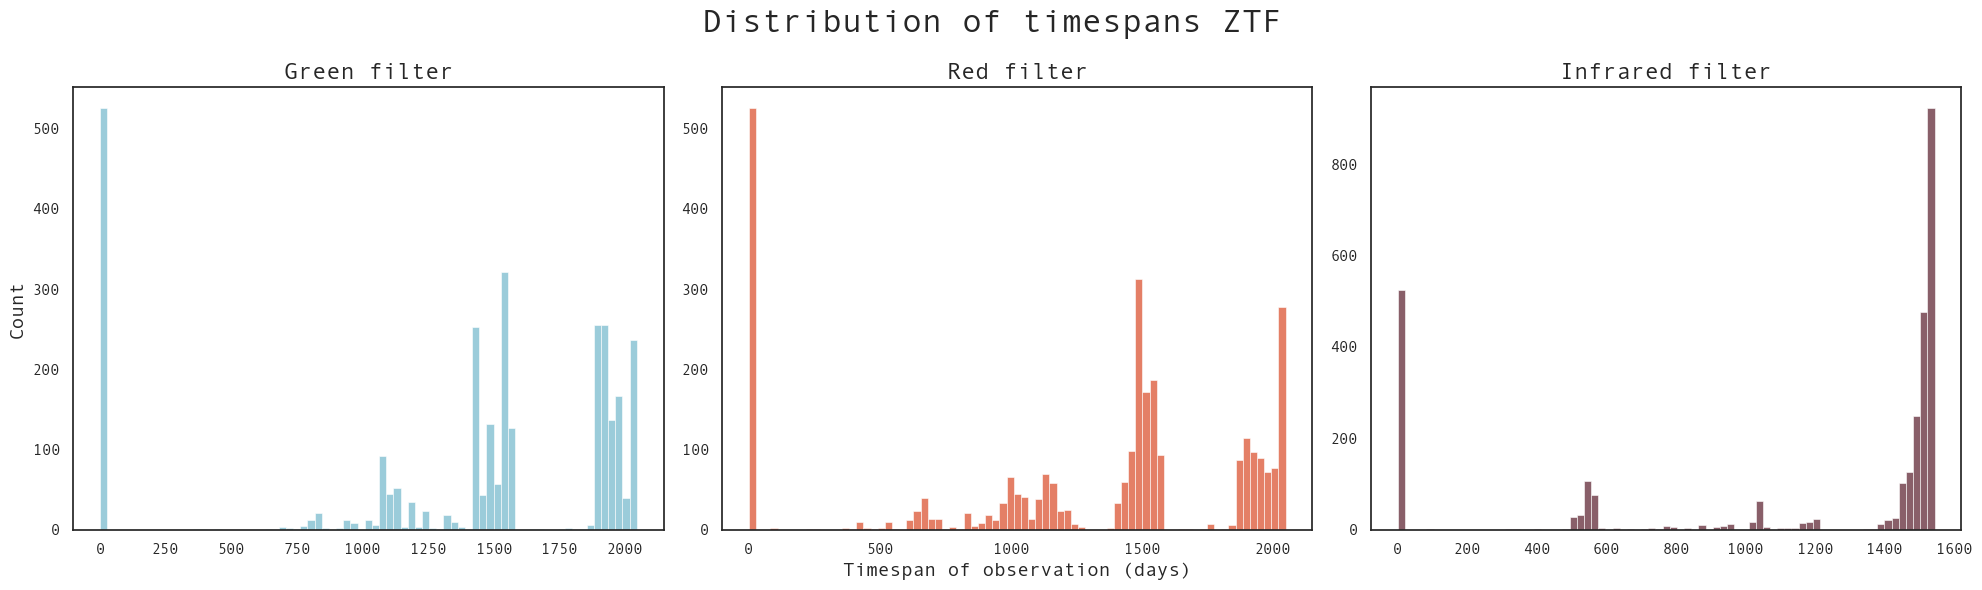

In [40]:
fig, ax = plt.subplots(1,3, figsize=(20,6)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes

fig.suptitle('Distribution of timespans ZTF', fontproperties=font,fontsize=24)

sns.histplot(data=pZf1,color=b3, ax=ax[0], bins=75) # drawing a histogram of the distribution of measurements
sns.histplot(data=pZf2,color=or3, ax=ax[1], bins=75)
sns.histplot(data=pZf3,color=or2, ax=ax[2], bins=75)

ax[1].set_xlabel('Timespan of observation (days)', fontproperties=font, fontsize=14)
ax[0].set_ylabel('Count', fontproperties=font,fontsize=14)
ax[1].set_ylabel(None)
ax[2].set_ylabel(None)
ax[0].set_title('Green filter', fontproperties=font, fontsize=17)
ax[1].set_title('Red filter', fontproperties=font, fontsize=17)
ax[2].set_title('Infrared filter', fontproperties=font, fontsize=17)
plt.savefig('../img_rsc/ZTF_timespan_distribution.png', dpi=650)
plt.tight_layout()
plt.show()

The observational time period for `ZTF` is very similar to that of `LINEAR`, but there are many `ZTF` stars with no observation data, or no observation data in a specific filter (which is why thhe peak at around 0 is so high). Subsequent peaks for the green and red filter are at ~1500 and ~1800 days of observation. The infrared filter is observed for the shortest period, with a peak at ~500 days and ~1500 days.

Before we begin with serious light curve analysis, we can take a look at the general distribution of RR Lyrae periods, amplitude of their light change, and see the distribution of RR Lyrae types (AB and C). 

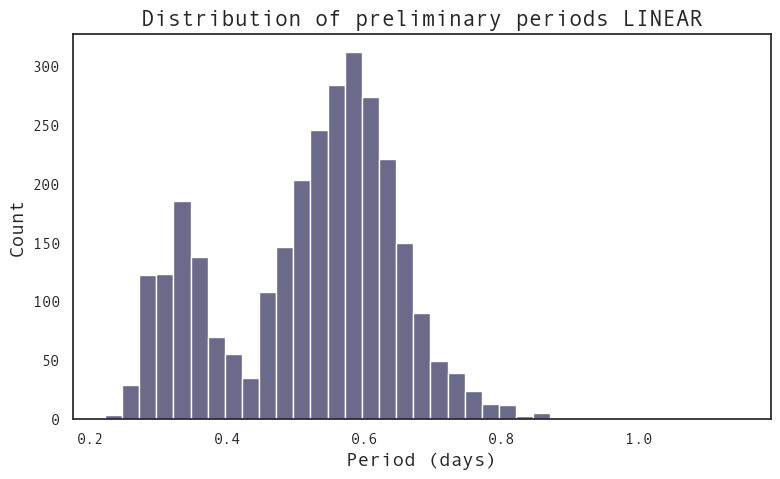

In [43]:
plt.figure(figsize=(9,5))
sns.histplot(data=(10**(dataL['logP'].to_numpy())),color=b4) # drawing a histogram of the distribution of measurements
plt.title('Distribution of preliminary periods LINEAR', fontproperties=font,fontsize=16)
plt.xlabel('Period (days)', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/preliminary_period_distribution.png', dpi=650)
plt.show()

From the preliminary analysis of only `LINEAR` periods for our set of RR Lyrae stars, we can see that the periods are very short, and within range of accepted values for RR lyrae stars. The largest peak is at ~0.6 days, with a smaller one at ~0.3 days.

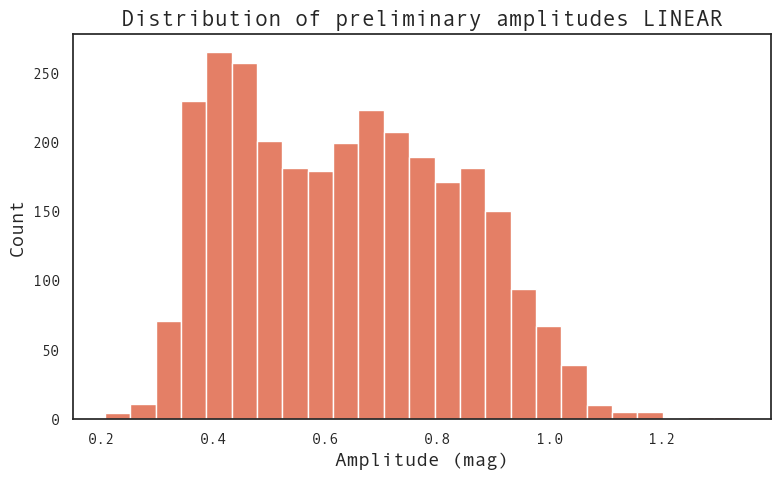

In [44]:
plt.figure(figsize=(9,5))
sns.histplot(data=dataL['Ampl'].to_numpy(),color=or3) # drawing a histogram of the distribution of measurements
plt.title('Distribution of preliminary amplitudes LINEAR', fontproperties=font,fontsize=16)
plt.xlabel('Amplitude (mag)', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/preliminary_ampl_distribution.png', dpi=650)
plt.show()

From the distribution above, all preliminary `LINEAR` amplitude values are within the reasonable limit of a change of 2 magnitudes, with a fairly even distribution from ~0.4 mag to ~0.9 mag change, which isn't negligible at all!

In [4]:
lc_counts = dataL['LCtype'].value_counts().reset_index()
lc_counts.columns = ['LCtype', 'Count']

In [5]:
lc_counts

,LCtype,Count
0,1,2196
1,2,745


In [50]:
p1 = round(lc_counts['Count'][0]/len(dataL['LINEARobjectID']),3)*100
p2 = round(lc_counts['Count'][1]/len(dataL['LINEARobjectID']), 3)*100
print(f'The percentage of RRAB stars is {p1}%, while for RRC stars it is {p2}% .')

The percentage of RRAB stars is 74.7%, while for RRC stars it is 25.3% .


# Positional analysis of stars

We can take a look at where our stars are in the night sky, to get a general feeling for RR Lyrae positional distribution. Later on, after thorough analysis of the light curves and the BE candidates, we will plot the same plot of the sky to determine the positional distribution of BE stars.

In [51]:
ids = dataL['LINEARobjectID'].to_numpy()

In [52]:
#| code-fold: false
# DETERMINING THE RECTASCENSION AND DECLINATION COORDS
rec_ab = []
dec_ab = []
RA = dataL['ra'].to_numpy()
DEC = dataL['dec'].to_numpy()

for i in range(len(ids)): # for every id in our dataset
    # look for the index of the current id in the total dataset of stellar attributes
    ra, dec = RA[i], DEC[i] # select rectascension and declination
    rec_ab.append(ra*u.deg) # convert ra into degrees for later conversion
    dec_ab.append(dec*u.deg) # convert dec into degrees for later conversion

print(len(rec_ab), len(dec_ab))

2941 2941


In [53]:
#| code-fold: false
# CONVERTING THE COORDINATES INTO GALACTIC COORDS

l_ab = []
b_ab = []

for k in range(len(rec_ab)): # for every star in our ab dataset
    # selection of ra and dec coords
    ra = rec_ab[k]
    dec = dec_ab[k]

    # converting them into galactic coordinates
    c = SkyCoord(ra=ra, dec=dec, frame='icrs')
    l = round(c.galactic.l.degree, 3)
    b = round(c.galactic.b.degree, 3)

    # convert the coordinates into a range from -180º to 180º for our projection 
    l_rad = np.radians(l)
    l_rad = np.mod(l_rad + np.pi, 2.0 * np.pi) - np.pi
    b_rad = np.radians(b)

    l_ab.append(l_rad)
    b_ab.append(b_rad)
print(len(l_ab), len(b_ab))

2941 2941


In [54]:
dataL['lab'] = l_ab
dataL['bab'] = b_ab
dataL.head()

,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,LINEARobjectID,lab,bab
0,119.526443,46.962120,1.166,0.369,1.018,0.269,-0.254138,0.619,-0.313,-0.567,16.37,301,1,29848,3.007010,0.532273
1,119.712975,52.149574,1.175,0.386,1.100,0.205,-0.191591,0.487,-0.291,-0.879,16.46,284,1,50402,2.902535,0.544962
2,119.187241,53.379295,1.123,0.207,1.074,0.210,-0.275092,0.624,-0.547,-0.322,16.54,276,1,62892,2.877001,0.541262
3,120.294960,40.932457,1.180,0.237,1.087,0.368,-0.170871,0.753,-0.121,-0.927,15.39,177,1,91437,3.128974,0.523843
4,120.124542,40.656620,1.178,-0.145,0.835,0.277,-0.503252,0.550,0.140,-0.650,16.98,222,2,95250,3.133913,0.520684


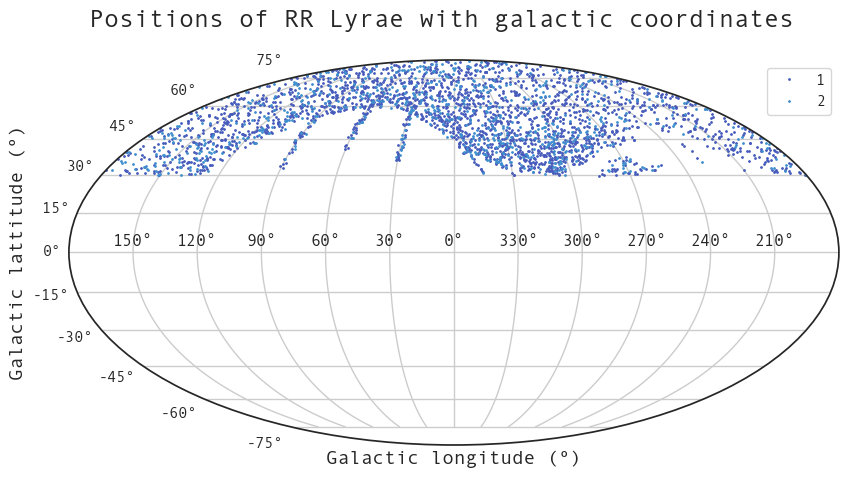

In [55]:
#| code-fold: false
# PLOTTING THE STARS

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide')
groups = dataL.groupby('LCtype')
for name, group in groups:
    plt.plot(group.lab, group.bab, marker='o', linestyle='', markersize=1, label=name)

ax.grid(True)
fig.suptitle('Positions of RR Lyrae with galactic coordinates', fontproperties=font,fontsize=18)
ax.set_xticks(np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]))
ax.set_xticklabels(['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'], fontproperties=font, fontsize=12)
ax.set_xlabel('Galactic longitude (º)', fontproperties=font, fontsize=14)
ax.set_ylabel('Galactic lattitude (º)', fontproperties=font, fontsize=14)
plt.legend()
plt.savefig('../img_rsc/galactic_coords_preliminary_rrlyrae.png', dpi=650)
plt.show()

As we can see, they are evenly distributed across the sky, with no particular order, regarding RRAB and RRC types. All stars are above the galactic horizon, over the entire span, above 30º galactic lattitude. 

---

# Next...

In the following notebooks we start with RR Lyrae analysis, developing a pipeline for efficient finding of new Blazhko stars.